<h1 align="center">OpenMP part 2</h1> 

## Exercise 1:

Using your code 2D non linear convection equation from the `numba_pyccel_assignments`:
1. Parallelize the 2D non linear convection equation
2. Compare cpu time using different number of threads (Plot a figure of cpu time according to number of threads)

In [1]:
import numpy as np
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D

import time

#fill the libraries import
from pyccel.epyccel import epyccel
from pyccel.decorators import types
from pyccel.stdlib.internal.openmp import omp_set_num_threads, omp_get_num_threads, omp_get_thread_num

In [13]:
def solve_2d_nonlinearconv_pure(u, un, v, vn, nt, dt, dx, dy):

    ###Assign initial conditions
    ##set hat function I.C. : u(.5<=x<=1 && .5<=y<=1 ) is 2
    u[int(.5 / dy):int(1 / dy + 1), int(.5 / dx):int(1 / dx + 1)] = 2
    ##set hat function I.C. : v(.5<=x<=1 && .5<=y<=1 ) is 2
    v[int(.5 / dy):int(1 / dy + 1), int(.5 / dx):int(1 / dx + 1)] = 2
    row, col = u.shape
    
    #fill the update of u and v
    for n in range(nt):
        for i in range (row):
            for j in range(col):
                un[i,j] = u[i,j]
                vn[i,j] = v[i,j]
        for i in range(1, row-1):
            for j in range(1,col-1):
                u[i,j] = un[i,j] - (un[i,j] *( dt / dx) * (un[i,j] - un[i-1,j])) - (vn[i,j] * (dt / dy) * (un[i,j] - un[i,j-1]))
                v[i,j] = vn[i,j] - (un[i,j] * (dt / dx) * (vn[i,j] - vn[i-1,j])) -( vn[i,j] * (dt / dy) * (vn[i,j] - vn[i,j-1]))
                

        
    return 0

### Inputs

/tmp/ipykernel_3218/4064944512.py:22: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')
/tmp/ipykernel_3218/4064944512.py:28: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


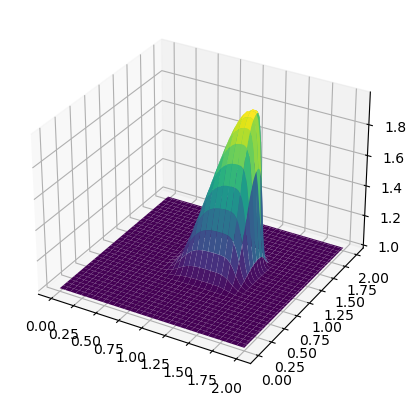

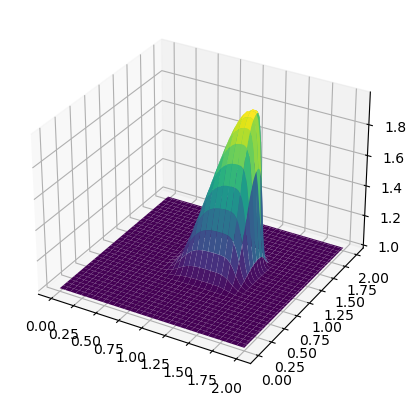

In [23]:
###variable declarations
nx = 101
ny = 101
nt = 80
#c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
sigma = .2
dt = sigma * dx

x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)

u = np.ones((ny, nx)) ##create a 1xn vector of 1's
v = np.ones((ny, nx))
un = np.ones((ny, nx))
vn = np.ones((ny, nx))     

solve_2d_nonlinearconv_pure(u, un, v, vn, nt, dt, dx, dy)

fig = pyplot.figure(figsize=(7, 5), dpi=100)
ax = fig.gca(projection='3d')                      
X, Y = np.meshgrid(x, y)                            
surf = ax.plot_surface(X, Y, u, cmap=cm.viridis)


fig = pyplot.figure(figsize=(7, 5), dpi=100)
ax = fig.gca(projection='3d')
surf2 = ax.plot_surface(X, Y, v, cmap=cm.viridis)

In [47]:
%%file nonlinearconv2d_pure.py
# write your code here
def solve_2d_nonlinearconv_pure(u: 'float[:,:]', un : 'float[:,:]', v : 'float[:,:]', vn : 'float[:,:]', nt : 'int', dt : 'float', dx :'float', dy : 'float'):

    ###Assign initial conditions
    ##set hat function I.C. : u(.5<=x<=1 && .5<=y<=1 ) is 2
    u[int(.5 / dy):int(1 / dy + 1), int(.5 / dx):int(1 / dx + 1)] = 2
    ##set hat function I.C. : v(.5<=x<=1 && .5<=y<=1 ) is 2
    v[int(.5 / dy):int(1 / dy + 1), int(.5 / dx):int(1 / dx + 1)] = 2
    row, col = u.shape
    
    #fill the update of u and v
    #$ omp parallel
    for n in range(nt):
        #pragma omp for collapse(2)
        for i in range (row):
            for j in range(col):
                un[i,j] = u[i,j]
                vn[i,j] = v[i,j]
        #pragma omp for collapse(2)
        for i in range(1, row-1):
            for j in range(1,col-1):
                u[i,j] = un[i,j] - (un[i,j] *( dt / dx) * (un[i,j] - un[i-1,j])) - (vn[i,j] * (dt / dy) * (un[i,j] - un[i,j-1]))
                v[i,j] = vn[i,j] - (un[i,j] * (dt / dx) * (vn[i,j] - vn[i-1,j])) -( vn[i,j] * (dt / dy) * (vn[i,j] - vn[i,j-1]))
    #$ omp end parallel
        
    return 0
if __name__ == "__main__" :
    
    import numpy as np
    
    ##variable declarations
    nx = 101
    ny = 101
    nt = 80
    #c = 1
    dx = 2 / (nx - 1)
    dy = 2 / (ny - 1)
    sigma = .2
    dt = sigma * dx


    u = np.ones((ny, nx)) ##create a 1xn vector of 1's
    v = np.ones((ny, nx))
    un = np.ones((ny, nx))
    vn = np.ones((ny, nx)) 
    
    solve_2d_nonlinearconv_pure(u, un, v, vn, nt, dt, dx, dy)

Overwriting nonlinearconv2d_pure.py


In [48]:
!pyccel nonlinearconv2d_pure.py --language=c --openmp

In [49]:
## Using 20 threads
start = time.process_time()

!export OMP_NUM_THREADS=20; ./nonlinearconv2d_pure

end = time.process_time()
t = end - start
print("CPU time = ", t)

CPU time =  0.010078065999998387


In [50]:
## Using 11 threads
start = time.process_time()

!export OMP_NUM_THREADS=10; ./nonlinearconv2d_pure

end = time.process_time()
t = end - start
print("CPU time = ", t)

CPU time =  0.01094772799999788


In [51]:
## Using 10 threads
start = time.process_time()

!export OMP_NUM_THREADS=10; ./nonlinearconv2d_pure

end = time.process_time()
t = end - start
print("CPU time = ", t)

CPU time =  0.009957179000004146


In [52]:
## Using 5 threads
start = time.process_time()

!export OMP_NUM_THREADS=5; ./nonlinearconv2d_pure

end = time.process_time()
t = end - start
print("CPU time = ", t)

CPU time =  0.010979232000003947


In [54]:
I = np.arange(1,21)
times = []
for i in I:
    start = time.process_time()

    !export OMP_NUM_THREADS=i; ./nonlinearconv2d_pure

    end = time.process_time()
    t = end - start
    
    print(i," threads - CPU time = ", t ,"\n")
    
    times.append(t)


libgomp: Invalid value for environment variable OMP_NUM_THREADS
1  threads - CPU time =  0.010777507000000242 


libgomp: Invalid value for environment variable OMP_NUM_THREADS
2  threads - CPU time =  0.010829696000001832 


libgomp: Invalid value for environment variable OMP_NUM_THREADS
3  threads - CPU time =  0.011139011000004473 


libgomp: Invalid value for environment variable OMP_NUM_THREADS
4  threads - CPU time =  0.010791928999999811 


libgomp: Invalid value for environment variable OMP_NUM_THREADS
5  threads - CPU time =  0.011684164000001829 


libgomp: Invalid value for environment variable OMP_NUM_THREADS
6  threads - CPU time =  0.01035127900000532 


libgomp: Invalid value for environment variable OMP_NUM_THREADS
7  threads - CPU time =  0.012343762999996954 


libgomp: Invalid value for environment variable OMP_NUM_THREADS
8  threads - CPU time =  0.010990284999998323 


libgomp: Invalid value for environment variable OMP_NUM_THREADS
9  threads - CPU time =  0.00780

(0.005, 0.015)

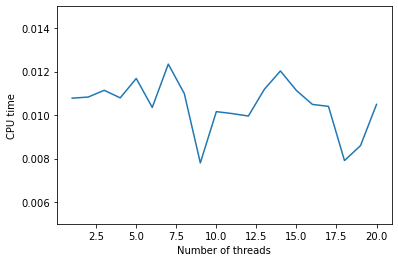

In [59]:
pyplot.plot(I,times)
pyplot.xlabel("Number of threads")
pyplot.ylabel("CPU time")
pyplot.ylim(0.005,0.015)

## Exercise 2:

Using your code Navier Stokes equation from the `numba_pyccel_assignments`:
1. Pyccelize the Navier Stokes equation (if it's not done).
2. Parallelize it using OpenMP.
3. Compare cpu time using different number of threads (Plot a figure of cpu time according to number of threads)

## Pure function

In [113]:
def build_up_b_pure(b, rho, dt, u, v, dx, dy):
    row, col = u.shape
        
        
    b[1:-1, 1:-1] = (rho * (1 / dt * ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))
                            - ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 - 2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                           (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx)) - ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))

    return b

def pressure_poisson_pure(p, dx, dy, b):
    pn = np.empty_like(p)
    pn = np.copy(p)
    
    for q in range(nit):
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 + (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /(2 * (dx**2 + dy**2)) 
                         - dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * b[1:-1,1:-1])

        p[:, -1] = p[:, -2] 
        p[0, :] = p[1, :]   
        p[:, 0] = p[:, 1]   
        p[-1, :] = 0        
        
        
    return p

def cavity_flow_pure(nt, u, v, dt, nx, ny, dx, dy, p, rho, nu):
    un = np.empty_like(u)
    vn = np.empty_like(v)
    b = np.zeros((ny, nx))
    
    pn = np.empty_like(p)
    pn = p.copy()
    
    for n in range(nt):
        un = u.copy()
        vn = v.copy()
        b = build_up_b_pure(b, rho, dt, u, v, dx, dy)
        p = pressure_poisson_pure(p, dx, dy, b)
        u[1:-1, 1:-1] = (un[1:-1, 1:-1] - un[1:-1, 1:-1] * dt / dx * (un[1:-1, 1:-1] - un[1:-1, 0:-2]) - vn[1:-1, 1:-1] * dt / 
                         dy * (un[1:-1, 1:-1] - un[0:-2, 1:-1]) - dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2])
                         + nu * (dt / dx**2 * (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) + dt / dy**2 *
                    (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))
        v[1:-1,1:-1] = (vn[1:-1, 1:-1] - un[1:-1, 1:-1] * dt / dx * (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) - vn[1:-1, 1:-1] * dt / dy *
                    (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) - dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) + nu * (dt / dx**2 *
                    (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) + dt / dy**2 * (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))

    u[0, :]  = 0
    u[:, 0]  = 0
    u[:, -1] = 0
    u[-1, :] = 1 
    v[0, :]  = 0
    v[-1, :] = 0
    v[:, 0]  = 0
    v[:, -1] = 0
        
        
    return u, v, p

## Inputs

In [114]:
import numpy as np
nx = 41
ny = 41
nt = 500
nit = 50
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)
X, Y = np.meshgrid(x, y)

rho = 1
nu = .1
dt = .001

u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
un = np.ones((ny, nx))
vn = np.ones((ny, nx))
p = np.zeros((ny, nx))
pn = np.ones((ny, nx)) 
b = np.zeros((ny, nx))

## Pyccelizing the Navier Stocks Function

In [115]:
def cavity_flow_pyc(b: 'float[:,:]',nt:'int', u: 'float[:,:]', v: 'float[:,:]', dt: 'float', nx: 'int', ny: 'int', dx: 'float', dy: 'float', p: 'float[:,:]', rho: 'int', nu:'float',un: 'float[:,:]',vn: 'float[:,:]',pn: 'float[:,:]'):
    
    row,col = u.shape
    
    
    for n in range(nt):
        for i in range(row):
            for j in range(col):
                un[i,j] = u[i,j]
                vn[i,j] = v [i,j]
                pn[i,j] = p [i,j]
                
        b[1:-1, 1:-1] = (rho * (1 / dt * ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))
                            - ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 - 2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                           (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx)) - ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))
        
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 + (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /(2 * (dx**2 + dy**2)) 
                         - dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * b[1:-1,1:-1])

        p[:, -1] = p[:, -2]
        p[0, :] = p[1, :]  
        p[:, 0] = p[:, 1]  
        p[-1, :] = 0 
         
        u[1:-1, 1:-1] = (un[1:-1, 1:-1] - un[1:-1, 1:-1] * dt / dx * (un[1:-1, 1:-1] - un[1:-1, 0:-2]) - vn[1:-1, 1:-1] * dt / 
                         dy * (un[1:-1, 1:-1] - un[0:-2, 1:-1]) - dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2])
                         + nu * (dt / dx**2 * (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) + dt / dy**2 *
                    (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))
        
        v[1:-1,1:-1] = (vn[1:-1, 1:-1] - un[1:-1, 1:-1] * dt / dx * (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) - vn[1:-1, 1:-1] * dt / dy *
                    (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) - dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) + nu * (dt / dx**2 *
                    (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) + dt / dy**2 * (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))

    u[0, :]  = 0
    u[:, 0]  = 0
    u[:, -1] = 0
    u[-1, :] = 1 
    v[0, :]  = 0
    v[-1, :] = 0
    v[:, 0]  = 0
    v[:, -1] = 0
        

In [116]:
cavity_flow_pyccel = epyccel(cavity_flow_pyc)

In [117]:
## pure Navier Stocks function
start = time.process_time()

cavity_flow_pure(nt, u, v, dt, nx, ny, dx, dy, p, rho, nu)

end = time.process_time()
t = end - start
print("CPU time = ", t)

CPU time =  1.3546020869999964


In [118]:
# Pyccilized Navier Stocks function
start = time.process_time()

cavity_flow_pyccel(b,nt, u, v, dt, nx, ny, dx, dy, p, rho, nu, un, vn, pn)

end = time.process_time()
t = end - start
print("CPU time = ", t)

CPU time =  0.026391085000000203


In [138]:
%%file NavierStocks_openmp.py

def cavity_flow_pyc(b: 'float[:,:]',nt:'int', u: 'float[:,:]', v: 'float[:,:]', dt: 'float', nx: 'int', ny: 'int', dx: 'float', dy: 'float', p: 'float[:,:]', rho: 'int', nu:'float',un: 'float[:,:]',vn: 'float[:,:]',pn: 'float[:,:]'):
    row,col = u.shape
    #$ omp parallel
    for n in range(nt):
        for i in range(row):
            for j in range(col):
                un[i,j] = u[i,j]
                vn[i,j] = v [i,j]
                pn[i,j] = p [i,j]
                
        b[1:-1, 1:-1] = (rho * (1 / dt * ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))
                            - ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 - 2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                           (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx)) - ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))
        
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 + (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /(2 * (dx**2 + dy**2)) 
                         - dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * b[1:-1,1:-1])

        p[:, -1] = p[:, -2]
        p[0, :] = p[1, :]  
        p[:, 0] = p[:, 1]  
        p[-1, :] = 0 
        
        u[1:-1, 1:-1] = (un[1:-1, 1:-1] - un[1:-1, 1:-1] * dt / dx * (un[1:-1, 1:-1] - un[1:-1, 0:-2]) - vn[1:-1, 1:-1] * dt / 
                         dy * (un[1:-1, 1:-1] - un[0:-2, 1:-1]) - dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2])
                         + nu * (dt / dx**2 * (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) + dt / dy**2 *
                    (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))
        
        v[1:-1,1:-1] = (vn[1:-1, 1:-1] - un[1:-1, 1:-1] * dt / dx * (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) - vn[1:-1, 1:-1] * dt / dy *
                    (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) - dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) + nu * (dt / dx**2 *
                    (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) + dt / dy**2 * (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))
    #$ omp end parallel

    u[0, :]  = 0
    u[:, 0]  = 0
    u[:, -1] = 0
    u[-1, :] = 1    
    v[0, :]  = 0
    v[-1, :] = 0
    v[:, 0]  = 0
    v[:, -1] = 0
    
if __name__ == "__main__":
    
    import numpy as np

    nx = 41
    ny = 41
    nt = 500
    nit = 50
    c = 1
    dx = 2 / (nx - 1)
    dy = 2 / (ny - 1)

    rho = 1
    nu = .1
    dt = .001

    u = np.zeros((ny, nx))
    v = np.zeros((ny, nx))
    un = np.ones((ny, nx))
    vn = np.ones((ny, nx))
    p = np.zeros((ny, nx))
    pn = np.ones((ny, nx)) 
    b = np.zeros((ny, nx))
    
    cavity_flow_pyc(b,nt, u, v, dt, nx, ny, dx, dy, p, rho, nu,un,vn,pn)  

Overwriting NavierStocks_openmp.py


In [140]:
!pyccel NavierStocks_openmp.py --language=c --openmp

In [141]:
#num threads = 20
start = time.process_time()

!export OMP_NUM_THREADS=20; ./NavierStocks_openmp

end = time.process_time()
t = end - start
print("CPU time = ", t)

CPU time =  0.012304165999992733


In [142]:
#num threads = 15
start = time.process_time()

!export OMP_NUM_THREADS=15; ./NavierStocks_openmp

end = time.process_time()
t = end - start
print("CPU time = ", t)

CPU time =  0.01203772699999206


In [143]:
#num threads = 10
start = time.process_time()

!export OMP_NUM_THREADS=10; ./NavierStocks_openmp

end = time.process_time()
t = end - start
print("CPU time = ", t)

CPU time =  0.011324317999992672


In [144]:
#num threads = 5
start = time.process_time()

!export OMP_NUM_THREADS=5; ./NavierStocks_openmp

end = time.process_time()
t = end - start
print("CPU time = ", t)

CPU time =  0.0085965919999893


In [145]:
I = np.arange(1,21)
times = []
for i in I:
    start = time.process_time()

    !export OMP_NUM_THREADS=i; ./NavierStocks_openmp

    end = time.process_time()
    t = end - start
    
    print(i," threads - CPU time = ", t ,"\n")
    
    times.append(t)


libgomp: Invalid value for environment variable OMP_NUM_THREADS
1  threads - CPU time =  0.011301996000000258 


libgomp: Invalid value for environment variable OMP_NUM_THREADS
2  threads - CPU time =  0.01166805299999396 


libgomp: Invalid value for environment variable OMP_NUM_THREADS
3  threads - CPU time =  0.011657905999996387 


libgomp: Invalid value for environment variable OMP_NUM_THREADS
4  threads - CPU time =  0.011245854999998528 


libgomp: Invalid value for environment variable OMP_NUM_THREADS
5  threads - CPU time =  0.011595818000003533 


libgomp: Invalid value for environment variable OMP_NUM_THREADS
6  threads - CPU time =  0.01026157400001182 


libgomp: Invalid value for environment variable OMP_NUM_THREADS
7  threads - CPU time =  0.011539236999993818 


libgomp: Invalid value for environment variable OMP_NUM_THREADS
8  threads - CPU time =  0.00827028400000529 


libgomp: Invalid value for environment variable OMP_NUM_THREADS
9  threads - CPU time =  0.0109466

(0.005, 0.015)

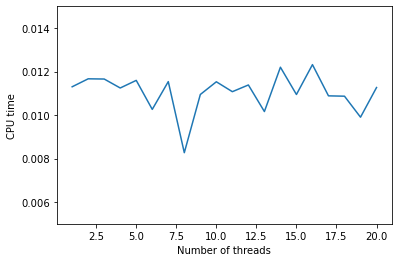

In [146]:
pyplot.plot(I,times)
pyplot.xlabel("Number of threads")
pyplot.ylabel("CPU time")
pyplot.ylim(0.005,0.015)